# OPTICS

For the additional we choose optics, the main points of this algorithm is being able to tackle diversity in the density. Also a very nice addition is the possibility of avoiding the usage of $Eps$ given how the algorithm is made and it should somehow overcome the main diversity issue.

All these shoud be able to avoid the shortcomings of DBSCAN.

In [1]:
from pyclustering.cluster.optics import optics
from pyclustering.cluster.optics import ordering_analyser
from pyclustering.utils import read_sample
from pyclustering.utils import draw_clusters
import datetime
from sklearn.cluster import OPTICS,DBSCAN
from os import path
import pandas as pd
from sklearn.preprocessing import StandardScaler
import utils
from scipy.sparse import csr_matrix

RACES_PATH=path.join("..","dataset","engineered_races.csv")
races_df=pd.read_csv(RACES_PATH)

num_columns = [
            'points',
            'length',
            'climb_total',
            'profile',
            'startlist_quality',
            'position',
            'cyclist_age',
            'delta',
            'climbing_efficiency',
            'competitive_age',
            'difficulty',
            'convenience_score',
            'difficulty_score',
            'performance_index',
            'gain_ratio',
 ]
data_df=races_df[num_columns].drop_duplicates().astype('float64').iloc[:1000]
data_df

,points,length,climb_total,profile,startlist_quality,position,cyclist_age,delta,climbing_efficiency,competitive_age,difficulty,convenience_score,difficulty_score,performance_index,gain_ratio
0,100.0,162000.0,1101.0,1.0,1241.0,0.0,22.0,0.0,0.006796,22.0,29292.971414,0.020686,0.635375,0.257143,157.387288
1,100.0,162000.0,1101.0,1.0,1241.0,1.0,27.0,0.0,0.006796,27.0,10253.271312,0.059106,0.635375,0.625564,157.387288
2,100.0,162000.0,1101.0,1.0,1241.0,2.0,24.0,0.0,0.006796,24.0,6932.135759,0.087424,0.635375,0.481066,157.387288
3,100.0,162000.0,1101.0,1.0,1241.0,3.0,30.0,0.0,0.006796,30.0,5985.755482,0.101247,0.635375,0.591388,157.387288
4,100.0,162000.0,1101.0,1.0,1241.0,4.0,27.0,0.0,0.006796,27.0,5084.548657,0.119193,0.635375,0.644566,157.387288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,50.0,154800.0,2008.0,2.0,659.0,33.0,35.0,101.0,0.012972,35.0,77768.364077,0.003893,0.994102,0.481203,50.296643
996,50.0,154800.0,2008.0,2.0,659.0,34.0,33.0,101.0,0.012972,33.0,37260.048701,0.008129,0.994102,0.502392,50.296643
997,50.0,154800.0,2008.0,2.0,659.0,35.0,36.0,101.0,0.012972,36.0,23337.430543,0.012981,0.994102,0.404375,50.296643
998,50.0,154800.0,2008.0,2.0,659.0,36.0,25.0,101.0,0.012972,25.0,62478.334549,0.004847,0.994102,0.591251,50.296643


In [2]:
from sklearn.preprocessing import StandardScaler

std_scaler=StandardScaler()

std_data=std_scaler.fit_transform(data_df)
#useful to estimatethe density of the dataset
maximum_distance=abs(std_data.max()-std_data.min()).sum().item()
average_concentration= std_data.shape[0]/maximum_distance

print(f"""
maximum distance={maximum_distance}
average concentration={average_concentration}
""")

std_data


maximum distance=7.7437444706661775
average concentration=129.13649253123822



array([[ 0.80248499,  0.49357889, -1.0542113 , ..., -1.10662662,
        -0.49791859,  1.15725478],
       [ 0.80248499,  0.49357889, -1.0542113 , ..., -1.10662662,
         1.56169474,  1.15725478],
       [ 0.80248499,  0.49357889, -1.0542113 , ..., -1.10662662,
         0.75389834,  1.15725478],
       ...,
       [-2.00537011,  0.37792118, -0.50878947, ..., -0.56227816,
         0.32516251, -0.59879836],
       [-2.00537011,  0.37792118, -0.50878947, ..., -0.56227816,
         1.36987176, -0.59879836],
       [-2.00537011,  0.37792118, -0.50878947, ..., -0.56227816,
         0.29917852, -0.59879836]])

So we need to setup the algorithm, i this case we want it to be able to run in reasonable amout of times we have to put a limit on the eps values available for this reason we fix eps at 10%. Given how the algorithms works its not necessary to set a value for eps but it is necessary to set one for the min samples, we apply the same reasoning here without havig to use the kneedle algorithm as in DBSCAN.

So first we take advtange of the algorithm and try a coarse grained approach to clustering.

In [10]:
import time

from sklearn.metrics import silhouette_score,davies_bouldin_score

n_dim=std_data.shape[1]
n_size=std_data.shape[0]

min_sample_values=[
    #testing using percentages
    int((n_size-1)*0.01),
    int((n_size-1)*0.02),
    int((n_size-1)*0.03),
    int((n_size-1)*0.04),
    int((n_size-1)*0.05),
    int((n_size-1)*0.1),
    #testing by also weighting it with the dimensionality
    int((n_size-1)*0.01*(1/n_dim)),
    int((n_size-1)*0.02*(1/n_dim)),
    int((n_size-1)*0.03*(1/n_dim)),
    int((n_size-1)*0.04*(1/n_dim)),
    int((n_size-1)*0.05*(1/n_dim)),
    int((n_size-1)*0.1*(1/n_dim)),
]

results=[]

for min_sample_size in min_sample_values:
    start=time.time()
    optics=OPTICS(
        min_samples=2 if min_sample_size < 2 else min_sample_size,
        max_eps=maximum_distance*0.1,
        n_jobs=-1
    )
    end=time.time()
    labels=optics.fit_predict(std_data)
    if not len(set(labels)) > 1:
        silhoutte_val= 'all labels equals'
        davies_bouldin_val= 'all labels equals'
    else:
        silhoutte_val=silhouette_score(std_data,labels)
        davies_bouldin_val=davies_bouldin_score(std_data,labels)

    results.append(
        {
            'min_samples':min_sample_size,
            'silhoutte_score':silhoutte_val,
            'davies_bouldin_score':davies_bouldin_val,
            'time(s)':(end-start)
        }
    )

results_df=pd.DataFrame(results)

9
19
29
39
49


/home/mirdan08/miniconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/cluster/_optics.py:661: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/home/mirdan08/miniconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/cluster/_optics.py:661: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/home/mirdan08/miniconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/cluster/_optics.py:661: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/home/mirdan08/miniconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/cluster/_optics.py:661: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


99
0


/home/mirdan08/miniconda3/envs/dmproj/lib/python3.12/site-packages/sklearn/cluster/_optics.py:661: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(


1
1
2
3
6


In [ ]:
top10_results=results_df[results_df['silhoutte_score']!='all labels equals'].sort_values(by='silhoutte_score',ascending=False).head(10)

top10_results

,min_samples,silhoutte_score,davies_bouldin_score,time(s)
6,0,0.017049,1.211919,0.000035
7,1,0.017049,1.211919,0.000122
8,1,0.017049,1.211919,0.000110
9,2,0.017049,1.211919,0.000078
0,9,-0.077159,1.185284,0.000082
10,3,-0.235082,1.286167,0.000086
11,6,-0.352006,1.291011,0.000216



best params 
min_samples                    0
silhoutte_score         0.017049
davies_bouldin_score    1.211919
time(s)                 0.000035
Name: 6, dtype: object



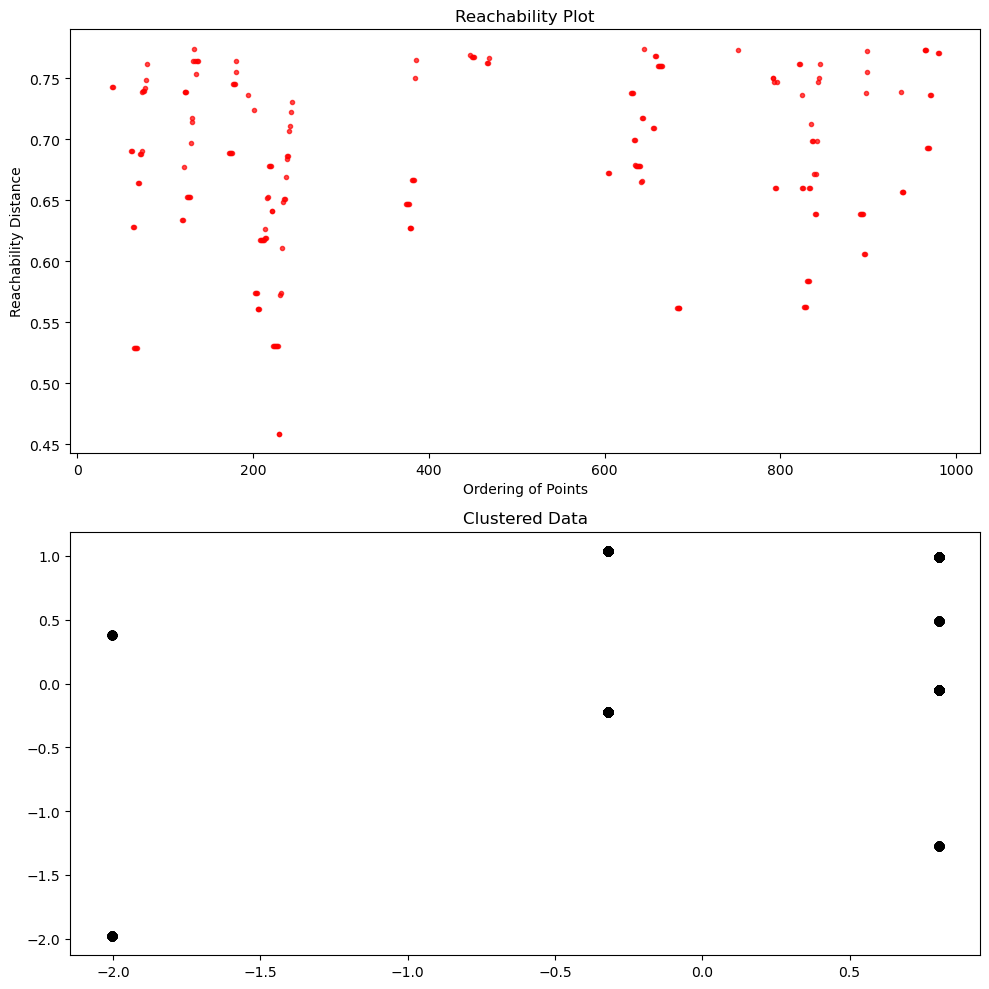

Extracted Clusters:
Cluster 0: [ 59  63  68  73  74  77  79  83  84  86  88  89  93  94  97  98  99 102
 103 104]
Cluster 1: [143 151 152 154 157 159 162 163]
Cluster 2: [172 173 174 176 177 178 181 183 194 197]
Cluster 3: [213 214 216 217 222 232 236]
Cluster 4: [221 227 228 229 234 242 243 246 247 248 258 259 261 269]
Cluster 5: [373 374 388 389 393 394 413 414 417 418 419 423 424]
Cluster 6: [629 633 636 637 640 642 646 647 648 651 655 659 663 664 668 681 688]
Cluster 7: [649 661 669 672 673 691]
Cluster 8: [790 798 810 814 822 823 835]
Cluster 9: [819 826 831 834 838 839 842 843 846 851 858]
Cluster 10: [890 894 898 902 903 906 907 918 926 927]
Cluster 11: [963 964 967 979 982 983 984 990 999]


In [25]:
import matplotlib.pyplot as plt
import numpy as np

best_params=top10_results.iloc[0]
print(f"""
best params 
{best_params}
""")
best_optics=OPTICS(
    min_samples= 2 if best_params['min_samples'] < 2 else best_params['min_samples'],
    max_eps=maximum_distance*0.1,
    n_jobs=-1
)
best_optics.fit(std_data)

labels=optics.labels_
reachability=optics.reachability_
ordering=optics.ordering_
core_distances= optics.core_distances_


# Visualize results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# 1. Reachability plot
ax1.set_title("Reachability Plot")
ax1.plot(np.arange(len(reachability)), reachability[ordering], 'r.', alpha=0.7)
ax1.set_ylabel("Reachability Distance")
ax1.set_xlabel("Ordering of Points")

# 2. Cluster visualization
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

ax2.set_title("Clustered Data")
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise

    class_member_mask = (labels == k)
    xy = std_data[class_member_mask]
    ax2.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.tight_layout()
plt.show()

# Extract clusters
clusters = {k: np.where(labels == k)[0] for k in unique_labels if k != -1}
print("Extracted Clusters:")
for cluster_id, points in clusters.items():
    print(f"Cluster {cluster_id}: {points}")